In [53]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### **Bibliotecas**

In [54]:
!pip install --upgrade calflops

In [55]:
import pandas as pd
import geopandas
import numpy as np
import os

from calflops import calculate_flops

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau

import ast
import math
import random
import time
import datetime
import itertools
from itertools import cycle
from tabulate import tabulate

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold
from sklearn.utils.class_weight import compute_class_weight

### **Configurações**

In [56]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
    print("Treinamento usando GPU.")
else:
    print("Treinamento usando CPU.")

Treinamento usando GPU.


In [57]:
seed = 18
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

#### **Definição dos *paths* das Entradas**

In [58]:
# alabama
path_nextpoi_input_alabama = '/content/drive/MyDrive/Graduacao/POC/Dados/pre-processing/alabama/nextpoi-input.csv'
path_categorypoi_input_alabama = '/content/drive/MyDrive/Graduacao/POC/Dados/pre-processing/alabama/categorypoi-input.csv'

# arizona
path_nextpoi_input_arizona = '/content/drive/MyDrive/Graduacao/POC/Dados/pre-processing/arizona/nextpoi-input.csv'
path_categorypoi_input_arizona = '/content/drive/MyDrive/Graduacao/POC/Dados/pre-processing/arizona/categorypoi-input.csv'

# virginia
path_nextpoi_input_virginia = '/content/drive/MyDrive/Graduacao/POC/Dados/pre-processing/virginia/nextpoi-input.csv'
path_categorypoi_input_virginia = '/content/drive/MyDrive/Graduacao/POC/Dados/pre-processing/virginia/categorypoi-input.csv'

# chicago
path_nextpoi_input_chicago = '/content/drive/MyDrive/Graduacao/POC/Dados/pre-processing/chicago/nextpoi-input.csv'
path_categorypoi_input_chicago = '/content/drive/MyDrive/Graduacao/POC/Dados/pre-processing/chicago/categorypoi-input.csv'

# georgia
path_nextpoi_input_georgia = '/content/drive/MyDrive/Graduacao/POC/Dados/pre-processing/georgia/nextpoi-input.csv'
path_categorypoi_input_georgia = '/content/drive/MyDrive/Graduacao/POC/Dados/pre-processing/georgia/categorypoi-input.csv'

#### **Inicialização do MlFlow**

In [59]:
!pip install mlflow
import mlflow

In [60]:
DAGSHUB_USER = "ingredalmeida1"
DAGSHUB_REPO = "poc"
DAGSHUB_TOKEN = "fcd26b772e42ea1a5e95651a69fb0adb7bd00e2e"
os.environ['MLFLOW_TRACKING_USERNAME'] = DAGSHUB_USER
os.environ['MLFLOW_TRACKING_PASSWORD'] = DAGSHUB_TOKEN
DAGSHUB_URL = f"https://dagshub.com/{DAGSHUB_USER}/{DAGSHUB_REPO}.mlflow"
mlflow.set_tracking_uri(DAGSHUB_URL)
mlflow.set_experiment("arizona")

<Experiment: artifact_location='mlflow-artifacts:/f345f50ab172460e96e7c28a3e8d3ed2', creation_time=1731443649144, experiment_id='3', last_update_time=1731443649144, lifecycle_stage='active', name='arizona', tags={}>

### **Funções utilitárias**

#### **Imprimir métricas**

In [61]:
id_to_name = {
    '0': 'Community',
    '1': 'Entertainment',
    '2': 'Food',
    '3': 'Nightlife',
    '4': 'Outdoors',
    '5': 'Shopping',
    '6': 'Travel'
}

In [62]:
def print_classification_report_train(y_true_category, y_pred_category, y_true_next, y_pred_next, id_to_name):
    category_report = classification_report(y_true_category, y_pred_category, zero_division=1, output_dict=True)
    next_report = classification_report(y_true_next, y_pred_next, zero_division=1, output_dict=True)

    category_df = pd.DataFrame(category_report).transpose()
    next_df = pd.DataFrame(next_report).transpose()

    category_df = category_df.drop(columns='support')
    category_df = category_df.drop(index=['weighted avg', 'accuracy'])

    next_df = next_df.drop(columns='support')
    next_df = next_df.drop(index=['weighted avg', 'accuracy'])

    category_df.rename(index=id_to_name, inplace=True)
    next_df.rename(index=id_to_name, inplace=True)

    category_df = category_df.transpose()
    next_df = next_df.transpose()

    category_df = category_df.map(lambda x: f"{x * 100:.1f}")
    next_df = next_df.map(lambda x: f"{x * 100:.1f}")

    print("\ncategory train metrics:")
    print(category_df.to_string())

    print("\n next train metrics:")
    print(next_df.to_string())

In [63]:
def print_classification_report_test(y_true, y_pred, id_to_name, task_name):
    report = classification_report(y_true, y_pred, zero_division=1, output_dict=True)

    metrics_df = pd.DataFrame(report).transpose()
    metrics_df = metrics_df.drop(columns='support')
    metrics_df = metrics_df.drop(index=['weighted avg', 'accuracy'])

    metrics_df.rename(index=id_to_name, inplace=True)
    metrics_df = metrics_df.transpose()

    metrics_df = metrics_df.map(lambda x: f"{x * 100:.1f}")

    print(f'{task_name} test metrics:')
    print(metrics_df.to_string() + '\n')

In [64]:
def print_classification_report_val(y_true, y_pred, id_to_name, task_name):
    report = classification_report(y_true, y_pred, zero_division=1, output_dict=True)

    metrics_df = pd.DataFrame(report).transpose()
    metrics_df = metrics_df.drop(columns='support')
    metrics_df = metrics_df.drop(index=['weighted avg', 'accuracy'])

    metrics_df.rename(index=id_to_name, inplace=True)
    metrics_df = metrics_df.transpose()

    metrics_df = metrics_df.map(lambda x: f"{x * 100:.1f}")

    print(f'validação {task_name} metrics:')
    print(metrics_df.to_string() + '\n')

#### **Imprimir perdas**

In [65]:
def print_train_losses(epoch, num_epochs, mtl_loss, next_loss, category_losss):
  print(f'\nEPOCH {epoch + 1}/{num_epochs}:')
  print(f'mtl loss: {mtl_loss:.1f}')
  print(f'next loss: {next_loss:.1f}')
  print(f'category loss: {category_losss:.1f}')

In [66]:
def print_val_losses(next_loss, category_losss):
  print(f'\nVALIDATION LOSSES:')
  print(f'next val loss: {next_loss:.1f}')
  print(f'category val loss: {category_losss:.1f}\n')

#### **Cálculo das Métricas**

In [67]:
def calculate_metrics_by_fold(fold_results, task_name):
    metrics = {
        'fold': [],
        'precision': [],
        'recall': [],
        'f1-score': []
    }

    for fold, results in fold_results.items():
        y_true = results[f'test_{task_name}_true']
        y_pred = results[f'test_{task_name}_pred']

        report = classification_report(y_true, y_pred, output_dict=True, zero_division=1)

        metrics['fold'].append(fold)
        metrics['precision'].append(report['macro avg']['precision'])
        metrics['recall'].append(report['macro avg']['recall'])
        metrics['f1-score'].append(report['macro avg']['f1-score'])

    return pd.DataFrame(metrics)

### **Input do Modelo MTL**

In [68]:
def x_y_to_tensor(x, y, task_name):
  x = torch.tensor(x.values, dtype=torch.float)
  y = torch.tensor(y.values, dtype=torch.long)

  if task_name == 'next':
     x = x.view(-1, 9, 100)
  else:
     x = x.view(-1, 1, 100)


  x.to(device)
  y.to(device)

  return x, y

def map_categories(y):
  id_to_name = {
    '0': 'Community',
    '1': 'Entertainment',
    '2': 'Food',
    '3': 'Nightlife',
    '4': 'Outdoors',
    '5': 'Shopping',
    '6': 'Travel',
    '7': 'None'
  }

  name_to_id = {name: int(id) for id, name in id_to_name.items()}
  try:
    y_encoded = np.array([[name_to_id[yi] for yi in row] for _, row in y.iterrows()])
  except:
    y_encoded = y.map(name_to_id)

  return y_encoded

#### **Input do Modelo NPC**

In [69]:
df_nextpoi_input = pd.read_csv(path_nextpoi_input_arizona)
print(df_nextpoi_input.shape)

usersids = df_nextpoi_input['userid'].unique().size
print(usersids)

(17242, 910)
756


In [70]:
target = df_nextpoi_input.columns[900:-1]

x_nextpoi = df_nextpoi_input.drop(target, axis=1)
y_nextpoi = df_nextpoi_input[target]
y_nextpoi = y_nextpoi.fillna('None')
y_nextpoi = map_categories(y_nextpoi)
y_nextpoi = pd.DataFrame(y_nextpoi)
print(x_nextpoi.shape, y_nextpoi.shape)

(17242, 901) (17242, 9)


#### **Input do Modelo PCat**

In [71]:
categorypoi_input = pd.read_csv(path_categorypoi_input_arizona)
print(categorypoi_input.shape)

placesids = categorypoi_input['placeid'].unique()
placesids = placesids.astype(int)
print(len(placesids))

categorypoi_input = categorypoi_input.set_index('placeid')
print(categorypoi_input.shape)

(16357, 102)
16357
(16357, 101)


In [72]:
x_categorypoi = categorypoi_input.drop('category', axis=1)
y_categorypoi = categorypoi_input['category']

y_categorypoi = map_categories(y_categorypoi)

print(x_categorypoi.shape, y_categorypoi.shape)

(16357, 100) (16357,)


### **Definição dos Datasets e Dataloaders**

In [73]:
class CustomDataset(Dataset):
    def __init__(self, input_features, true_y):
        self.input_features = input_features
        self.true_y = true_y

    def __len__(self):
        return len(self.input_features)

    def __getitem__(self, idx):
        sample = {
            'x': self.input_features[idx],
            'y': self.true_y[idx]
        }
        return sample

In [74]:
def input_to_dataloader(x, y, batch_size=32, shuffle=True):
  dataset = CustomDataset(x, y)
  dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
  return dataloader

### **Arquitetura do Modelo**

#### **Arquitetura do Modelo NPC**

In [75]:
class PositionalEncoding(nn.Module):
    def __init__(self, embed_dim, max_seq_length=5000, dropout=0.1):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        positional_encoding = torch.zeros(max_seq_length, embed_dim)
        positions = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_dim, 2).float() * (-math.log(10000.0) / embed_dim))

        positional_encoding[:, 0::2] = torch.sin(positions * div_term)
        positional_encoding[:, 1::2] = torch.cos(positions * div_term)

        positional_encoding = positional_encoding.unsqueeze(0)

        self.register_buffer('positional_encoding', positional_encoding)

    def forward(self, x):
        seq_length = x.size(1)
        x = x + self.positional_encoding[:, :seq_length, :]

        return self.dropout(x)

In [76]:
class NPC(nn.Module):
    def __init__(self, embed_dim, num_classes, num_heads, seq_length, num_layers, dropout=0.1):
        super(NPC, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.seq_length = seq_length
        self.pe = PositionalEncoding(embed_dim, 9)

        encoder_layer = nn.TransformerEncoderLayer(
            embed_dim,
            num_heads,
            dim_feedforward=embed_dim,
            dropout=dropout,
            batch_first=True,
            norm_first=True
        )

        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers)
        self.linear_layers = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        x = self.pe(x)

        batch_size, seq_length, _ = x.size()

        attn_mask = torch.triu(torch.ones(seq_length, seq_length) * float('-inf'), diagonal=1).to(x.device)

        x = self.transformer_encoder(x, mask=attn_mask)
        x = self.linear_layers(x)

        return x

#### **Arquitetura do Modelo PCat**

In [77]:
class PoiCat(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(PoiCat, self).__init__()

        self.hidden_layer1 = 1024
        self.hidden_layer2 = 512
        self.hidden_layer3 = 256
        self.latent_space = 128

        self.encoder = nn.Sequential(
            nn.Linear(input_dim, self.hidden_layer1),
            nn.LeakyReLU(),
            nn.Linear(self.hidden_layer1, self.hidden_layer2),
            nn.LeakyReLU(),
            nn.Linear(self.hidden_layer2, self.hidden_layer3),
            nn.LeakyReLU(),
            nn.Linear(self.hidden_layer3, self.latent_space),
            nn.LeakyReLU()
        )

        self.decoder = nn.Sequential(
            nn.Linear(self.latent_space, self.hidden_layer3),
            nn.LeakyReLU(),
            nn.Linear(self.hidden_layer3, self.hidden_layer2),
            nn.LeakyReLU(),
            nn.Linear(self.hidden_layer2, self.hidden_layer1),
            nn.LeakyReLU(),
            nn.Linear(self.hidden_layer1, input_dim),
            nn.LeakyReLU(),
            nn.Linear(256, 100)
        )

        self.classifier = nn.Sequential(
            nn.Linear(self.latent_space, num_classes),
            nn.Softmax(dim=-1)
        )

    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        out = self.classifier(latent)
        return out, reconstructed

#### **Arquitetura do Modelo MTL-POI**

In [78]:
class MTLPOI(nn.Module):
    def __init__(self, input_dim, shared_layer_size, num_classes, num_heads, num_layers, seq_length, num_shared_layers):
        super(MTLPOI, self).__init__()
        self.num_classes = num_classes
        self.input_dim = input_dim
        self.embedding = torch.nn.Embedding(1, input_dim)

        shared_linear_layers = []
        shared_linear_layers.append(nn.Linear(input_dim, shared_layer_size))
        shared_linear_layers.append(nn.LeakyReLU())
        shared_linear_layers.append(nn.Dropout())

        for _ in range(num_shared_layers - 1):
            shared_linear_layers.append(nn.Linear(shared_layer_size, shared_layer_size))
            shared_linear_layers.append(nn.LeakyReLU())
            shared_linear_layers.append(nn.Dropout())

        self.shared_layers = nn.Sequential(*shared_linear_layers)

        self.pcat = PoiCat(shared_layer_size, num_classes)
        self.npc = NPC(shared_layer_size, num_classes, num_heads, seq_length, num_layers)

    def forward(self, x1, x2):
      # print("Entrando no forward do MTLPOI")
      # print(f"Shape de x1: {x1.shape}, Shape de x2: {x2.shape}")

      idxs = x2.sum(-1) == 0

      if torch.any(idxs):
        replace_tensor = self.embedding(torch.tensor(0, dtype=torch.long).to(device))
        x2[idxs] = replace_tensor

      shared_output1 = self.shared_layers(x1)
      shared_output2 = self.shared_layers(x2)

      # print(f"Shape de shared_output1: {shared_output1.shape}")
      # print(f"Shape de shared_output2: {shared_output2.shape}")

      out1, r = self.pcat(shared_output1)
      # print(f"Shape de out1: {out1.shape}")

      out2 = self.npc(shared_output2)
      # print(f"Shape de out2: {out2.shape}")

      # out1 = out1.view(-1, self.num_classes)
      # print(f"Shape de out1: {out1.shape}")

      return out1, r, out2

    def forward_nextpoi(self, x):
        idxs = x.sum(-1) == 0
        x[idxs] = self.embedding(torch.tensor(0,dtype=torch.long).to(device))

        shared_output = self.shared_layers(x)

        out = self.npc(shared_output)

        return out

    def forward_categorypoi(self, x):
        shared_output = self.shared_layers(x)

        out, r = self.pcat(shared_output)

        return out, r

### **Cálculo do FLOPs do Modelo**

In [79]:
model = MTLPOI(
      input_dim=100,
      shared_layer_size=256,
      num_classes=7,
      num_heads=8,
      num_layers=4,
      seq_length=9,
      num_shared_layers=4,
    )

model = model.to(device)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


In [80]:
x_nextpoi_ = x_nextpoi.copy()
x_nextpoi_.userid = x_nextpoi_.userid.astype(int)
usersids = x_nextpoi_['userid'].unique()

train_user_index, test_user_index = train_test_split(usersids, test_size=0.25, random_state=42)

train_place_index, test_place_index = train_test_split(x_categorypoi.index, test_size=0.25, random_state=42)

train_user_index, val_user_index = train_test_split(train_user_index, test_size=0.25, random_state=42)
train_place_index, val_place_index = train_test_split(train_place_index, test_size=0.25, random_state=42)

train_index_next = x_nextpoi_[x_nextpoi_['userid'].isin(train_user_index)].index
x_nextpoi_ = x_nextpoi_.drop('userid', axis=1)

y_nextpoi_ = y_nextpoi.copy()
x_nextpoi_, y_nextpoi_ = x_y_to_tensor(x_nextpoi_, y_nextpoi_, 'next')
x_train_next = x_nextpoi_[train_index_next]
y_train_next = y_nextpoi_[train_index_next]

x_categorypoi_ = x_categorypoi.copy()
y_categorypoi_ = y_categorypoi.copy()
x_categorypoi_, y_categorypoi_ = x_y_to_tensor(x_categorypoi_, y_categorypoi_, 'category')

if isinstance(x_categorypoi_, torch.Tensor):
    train_place_index, test_place_index = train_test_split(torch.arange(x_categorypoi_.size(0)), test_size=0.25, random_state=42)
    train_place_index, val_place_index = train_test_split(train_place_index, test_size=0.25, random_state=42)

    x_train_category = x_categorypoi_[train_place_index]
    y_train_category = y_categorypoi_[train_place_index]

    x_test_category = x_categorypoi_[test_place_index]
    y_test_category = y_categorypoi_[test_place_index]

    x_val_category = x_categorypoi_[val_place_index]
    y_val_category = y_categorypoi_[val_place_index]
else:
    raise TypeError("x_categorypoi should be a tensor")

next_dataloader_train = input_to_dataloader(x_train_next, y_train_next)
category_dataloader_train = input_to_dataloader(x_train_category, y_train_category)

In [81]:
print("Tamanho de x_categorypoi:", x_categorypoi.shape[0])
print("train_place_index:", train_place_index)
print("test_place_index:", test_place_index)
print("val_place_index:", val_place_index)
print(type(x_categorypoi))

Tamanho de x_categorypoi: 16357
train_place_index: tensor([12860, 12714,  3446,  ...,  4908,  5038,  7032])
test_place_index: tensor([  387,  5635,  4230,  ..., 13199,  5659,  6962])
val_place_index: tensor([10296, 15068,  9967,  ...,  4676,  7927, 15912])
<class 'pandas.core.frame.DataFrame'>


In [82]:
first_batch_categorypoi = next(iter(category_dataloader_train))
x1 = first_batch_categorypoi['x']

first_batch_nextpoi = next(iter(next_dataloader_train))
x2 = first_batch_nextpoi['x']

x1 = x1.to(device)
x2 = x2.to(device)

print(f'x1.shape -> {x1.shape}')
print(f'x2.shape -> {x2.shape}')

x1.shape -> torch.Size([32, 1, 100])
x2.shape -> torch.Size([32, 9, 100])


In [83]:
# shared_output1 = model.shared_layers(x1)
# print("Passou shared_layers x1:", shared_output1.shape)

# shared_output2 = model.shared_layers(x2)
# print("Passou shared_layers x2:", shared_output2.shape)

# # out1, r = self.pcat(shared_output1.squeeze(1))
# out1, r = model.pcat(shared_output1)
# print("Passou PoiCat")

# out2 = model.npc(shared_output2)
# print("Passou NPC")

In [84]:
flops, macs, params = calculate_flops(model=model,
                                          kwargs={'x1': x1, 'x2': x2},
                                          print_results=False)

print("FLOPs: %s   MACs: %s   Params: %s" %(flops, macs, params))

flops = {
        'flops': flops,
        'macs': macs,
        'params': params,
}

FLOPs: 1.18 GFLOPS   MACs: 586.27 MMACs   Params: 3.74 M


### **Treinamento e Teste do Modelo**

#### **Definição da Função de Validação**

In [85]:
def val_model(model, loss_function_NPC, loss_function_PCat, loss_function_PCat2, one_hot, dataloader, id_to_name, task_name):
  y_true = []
  y_pred = []
  running_loss = 0.0
  steps = 0

  model.eval()

  with torch.no_grad():
      for data in dataloader:
          x, y = data['x'], data['y']
          x = x.to(device)
          y = y.to(device)

          if task_name == 'next':
            out = model.forward_nextpoi(x)

            B, S, _ = out.shape
            out = out.view(B * S , -1)
            y = y.view(B * S , -1)

            valid_samples = y < 7
            expanded_mask = valid_samples.expand(-1, out.shape[1])

            y = y[valid_samples]
            out = out[expanded_mask].view(-1, 7)

            predicted = torch.argmax(out, dim=-1)
            y_true.extend(y.tolist())
            y_pred.extend(predicted.tolist())

            # y_one_hot = one_hot[y]
            loss = loss_function_PCat(out, y)
            # loss = loss_function_NPC(out, y)
            running_loss += loss.item()
            steps += 1

          else:
            out, r = model.forward_categorypoi(x)
            out = out.squeeze(1)

            predicted = torch.argmax(out, dim=-1)
            y_true.extend(y.tolist())
            y_pred.extend(predicted.tolist())
            y_one_hot = one_hot[y]

            classifier_loss = loss_function_PCat(out, y_one_hot)
            encoder_loss = loss_function_PCat2(r, x)

            loss = classifier_loss + encoder_loss
            running_loss += loss.item()
            steps += 1

  average_loss = running_loss / steps if steps > 0 else 0.0

  print_classification_report_val(y_true, y_pred, id_to_name, task_name)

  return y_true, y_pred, average_loss

#### **Definição da Função de Teste**

In [86]:
def test_model(model, dataloader, id_to_name, task_name):
  print(f'\nTESTE {task_name.upper()}\n')

  y_true = []
  y_pred = []

  model.eval()

  with torch.no_grad():
      for data in dataloader:
          x, y = data['x'], data['y']
          x = x.to(device)
          y = y.to(device)

          if task_name == 'next':
            out = model.forward_nextpoi(x)
            predicted = torch.argmax(out, dim=-1)

            valid_samples = y < 7

            y = y[valid_samples]
            predicted = predicted[valid_samples]

            y_true.extend(y.view(-1).tolist())
            y_pred.extend(predicted.view(-1).tolist())

          else:
            out, r = model.forward_categorypoi(x)
            # out = out.squeeze(1)
            predicted = torch.argmax(out, dim=-1)
            y_true.extend(y.tolist())
            y_pred.extend(predicted.tolist())

      print_classification_report_test(y_true, y_pred, id_to_name, task_name)
      print()

  return y_true, y_pred

#### **Definição da Função de Treino**

In [87]:
def train_model_by_fold(model, optimizer, scheduler, next_dataloader_train, category_dataloader_train, next_dataloader_val,
                        category_dataloader_val, loss_function_NPC, loss_function_PCat, loss_function_PCat2, one_hot, num_epochs, id_to_name, print_interval=1):
    mtl_train_losses = []
    next_losses = []
    category_losses = []
    next_val_losses = []
    category_val_losses = []

    for epoch in range(num_epochs):
        model.train()

        running_loss = 0.0
        next_running_loss = 0.0
        category_running_loss = 0.0
        max_norm = 1.0

        y_true_category = []
        y_pred_category = []
        y_true_next = []
        y_pred_next = []

        steps = 0
        category_iter = cycle(category_dataloader_train)

        for data_next in next_dataloader_train:
            data_category = next(category_iter)
            optimizer.zero_grad()

            x_next, y_next = data_next['x'], data_next['y']
            x_next = x_next.to(device)
            y_next = y_next.to(device)

            x_category, y_category = data_category['x'], data_category['y']
            x_category = x_category.to(device)
            y_category = y_category.to(device)

            out_category, r, out_next = model(x_category, x_next)

            category_predicted = torch.argmax(out_category, dim=-1)
            y_true_category.extend(y_category.tolist())
            y_pred_category.extend(category_predicted.tolist())

            B, S, _ = out_next.shape
            out_next = out_next.view(B * S , -1)
            y_next = y_next.view(B * S , -1)
            idx_valid = (y_next < num_classes).view(-1)
            y_next = y_next[idx_valid].view(-1)
            out_next = out_next[idx_valid]
            next_predicted = torch.argmax(out_next, dim=-1)
            y_true_next.extend(y_next.tolist())
            y_pred_next.extend(next_predicted.view(-1).tolist())
            out_next = out_next.view(-1, num_classes)

            # loss_next = loss_function_NPC(out_next, y_next)
            loss_next = loss_function_PCat(out_next, y_next)

            out_category = out_category.squeeze(1)
            loss_PCat_cl = loss_function_PCat(out_category, y_category.view(-1))
            loss_PCat_enc = loss_function_PCat2(r, x_category)
            loss_category = loss_PCat_cl + loss_PCat_enc

            loss = loss_next + loss_category
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)

            optimizer.step()

            steps += 1
            running_loss += loss.item()
            next_running_loss += loss_next.item()
            category_running_loss += loss_category.item()

        if steps > 0:
            if (epoch + 1) % print_interval == 0 or epoch == 0:
                mtl_loss_by_epoch = running_loss / steps
                next_loss_by_epoch = next_running_loss / steps
                category_loss_by_epoch = category_running_loss / steps

                mtl_train_losses.append(mtl_loss_by_epoch)
                next_losses.append(next_loss_by_epoch)
                category_losses.append(category_loss_by_epoch)
                print_train_losses(epoch, num_epochs, mtl_loss_by_epoch, next_loss_by_epoch, category_loss_by_epoch)
                print_classification_report_train(y_true_category, y_pred_category, y_true_next, y_pred_next, id_to_name)
                print()
                print("-" * 110)
                print()

                model.eval()

                # validação category
                val_y_true_category, val_y_pred_category, category_val_loss = val_model(model,
                                                                                        loss_function_NPC,
                                                                                        loss_function_PCat,
                                                                                        loss_function_PCat2,
                                                                                        one_hot,
                                                                                        category_dataloader_val,
                                                                                        id_to_name,
                                                                                        'category')
                category_val_losses.append(category_val_loss)

                # validação next
                val_y_true_next, val_y_pred_next, next_val_loss = val_model(model, loss_function_NPC,
                                                                            loss_function_PCat,
                                                                            loss_function_PCat2,
                                                                            one_hot, next_dataloader_val,
                                                                            id_to_name, 'next')
                next_val_losses.append(next_val_loss)
                print("*" * 110)

                print_val_losses(next_val_loss, category_val_loss)

                scheduler.step(mtl_loss_by_epoch)

    results = {'mtl_train_losses': mtl_train_losses,
               'next_losses': next_losses,
               'category_losses': category_losses,
               'next_val_losses': next_val_losses,
               'category_val_losses': category_val_losses,
               'y_true_category': y_true_category,
               'y_pred_category': y_pred_category,
               'y_true_next': y_true_next,
               'y_pred_next': y_pred_next,
               'val_y_true_category': val_y_true_category,
               'val_y_pred_category': val_y_pred_category,
               'val_y_true_next': val_y_true_next,
               'val_y_pred_next': val_y_pred_next
               }

    return results

#### **Treino do Modelo com Validação Cruzada**

In [ ]:
num_classes = 7
num_epochs = 50
fold = 1
print_interval = 1
learning_rate = 0.0001

kf = KFold(n_splits=5, shuffle=True, random_state=42)
one_hot = torch.eye(num_classes).to(device)

try:
  x_nextpoi.userid = x_nextpoi.userid.astype(int)
  usersids = x_nextpoi['userid'].unique()
except:
  pass

fold_results_test = {}
fold_results_train = {}
fold_losses_train = {}
fold_results_val = {}
fold_losses_val = {}

for (train_user_index, test_user_index), (train_place_index, test_place_index) in zip(kf.split(usersids), kf.split(x_categorypoi)):
    print("#" * 110)
    print(f'FOLD {fold}:')

    try:
      x_nextpoi = _x_nextpoi.copy()
      y_nextpoi = _y_nextpoi.copy()
      x_categorypoi = _x_categorypoi.copy()
      y_categorypoi = _y_categorypoi.copy()
    except:
      _x_nextpoi = x_nextpoi.copy()
      _y_nextpoi = y_nextpoi.copy()
      _x_categorypoi = x_categorypoi.copy()
      _y_categorypoi = y_categorypoi.copy()

    model = MTLPOI(
      input_dim=100,
      shared_layer_size=256,
      num_classes=num_classes,
      num_heads=8,
      num_layers=4,
      seq_length=9,
      num_shared_layers=4,
    )

    model = model.to(device)
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    scheduler = ReduceLROnPlateau(optimizer, 'min')

    # val e train
    train_user_index, val_user_index = train_test_split(train_user_index, test_size=0.25, random_state=42)
    train_place_index, val_place_index = train_test_split(train_place_index, test_size=0.25, random_state=42)

    # indexs para o split pro nextpoi
    train_index_next = x_nextpoi[x_nextpoi['userid'].isin(usersids[train_user_index])].index
    val_index_next = x_nextpoi[x_nextpoi['userid'].isin(usersids[val_user_index])].index
    test_index_next = x_nextpoi[x_nextpoi['userid'].isin(usersids[test_user_index])].index
    x_nextpoi = x_nextpoi.drop('userid', axis=1)

    # train, test e val pro nextpoi
    x_nextpoi, y_nextpoi = x_y_to_tensor(x_nextpoi, y_nextpoi, 'next')
    x_train_next, x_test_next, x_val_next = x_nextpoi[train_index_next], x_nextpoi[test_index_next], x_nextpoi[val_index_next]
    y_train_next, y_test_next, y_val_next = y_nextpoi[train_index_next], y_nextpoi[test_index_next], y_nextpoi[val_index_next]

    loss_function_NPC = nn.CrossEntropyLoss()

    # train, test e val pro categorypoi
    x_categorypoi, y_categorypoi = x_y_to_tensor(x_categorypoi, y_categorypoi, 'category')
    x_train_category, x_test_category, x_val_category = x_categorypoi[train_place_index], x_categorypoi[test_place_index], x_categorypoi[val_place_index]
    y_train_category, y_test_category, y_val_category = y_categorypoi[train_place_index], y_categorypoi[test_place_index], y_categorypoi[val_place_index]

    class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train_category.cpu().numpy()), y=y_train_category.cpu().numpy())
    class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
    loss_function_PCat = nn.CrossEntropyLoss(weight=class_weights)
    loss_function_PCat2 = nn.MSELoss()

    # dataloaders nextpoi
    next_dataloader_train = input_to_dataloader(x_train_next, y_train_next)
    next_dataloader_test = input_to_dataloader(x_test_next, y_test_next)
    next_dataloader_val = input_to_dataloader(x_val_next, y_val_next)

    # dataloaders categorypoi
    category_dataloader_train = input_to_dataloader(x_train_category, y_train_category)
    category_dataloader_test = input_to_dataloader(x_test_category, y_test_category)
    category_dataloader_val = input_to_dataloader(x_val_category, y_val_category)

    fold_results_test[fold] = {
        'test_next_true': [],
        'test_next_pred': [],
        'test_category_true': [],
        'test_category_pred': []
    }

    fold_results_train[fold] = {
        'train_next_true': [],
        'train_next_pred': [],
        'train_category_true': [],
        'train_category_pred': [],
    }

    fold_results_val[fold] = {
        'val_next_true': [],
        'val_next_pred': [],
        'val_category_true': [],
        'val_category_pred': [],
    }

    fold_losses_train[fold] = {
        'mtl_train_losses': [],
        'next_losses': [],
        'category_losses': []
    }

    fold_losses_val[fold] = {
        'next_val_losses': [],
        'category_val_losses': [],
    }

    # train mtl model
    results = train_model_by_fold(model, optimizer, scheduler, next_dataloader_train, category_dataloader_train,
                                  next_dataloader_val, category_dataloader_val, loss_function_NPC,
                                  loss_function_PCat, loss_function_PCat2, one_hot, num_epochs, id_to_name)

    fold_losses_train[fold]['mtl_train_losses'] = results['mtl_train_losses']
    fold_losses_train[fold]['next_losses'] = results['next_losses']
    fold_losses_train[fold]['category_losses'] = results['category_losses']

    fold_losses_val[fold]['next_val_losses'] = results['next_val_losses']
    fold_losses_val[fold]['category_val_losses'] = results['category_val_losses']

    fold_results_train[fold]['train_next_true'] = results['y_true_next']
    fold_results_train[fold]['train_next_pred'] = results['y_pred_next']
    fold_results_train[fold]['train_category_true'] = results['y_true_category']
    fold_results_train[fold]['train_category_pred'] = results['y_pred_category']

    fold_results_val[fold]['val_next_true'] = results['val_y_true_next']
    fold_results_val[fold]['val_next_pred'] = results['val_y_pred_next']
    fold_results_val[fold]['val_category_true'] = results['val_y_true_category']
    fold_results_val[fold]['val_category_pred'] = results['val_y_pred_category']

    # test next
    y_true_test_next, y_pred_test_next = test_model(model, next_dataloader_test, id_to_name, 'next')
    fold_results_test[fold]['test_next_true'] = y_true_test_next
    fold_results_test[fold]['test_next_pred'] = y_pred_test_next

    # test category
    y_true_test_category, y_pred_test_category = test_model(model, category_dataloader_test, id_to_name, 'category')
    fold_results_test[fold]['test_category_true'] = y_true_test_category
    fold_results_test[fold]['test_category_pred'] = y_pred_test_category

    fold += 1

##############################################################################################################
FOLD 1:


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(



EPOCH 1/50:
mtl loss: 4.8
next loss: 2.0
category loss: 2.8

category train metrics:
          Community Entertainment  Food Nightlife Outdoors Shopping Travel macro avg
precision      11.0         100.0  32.7       0.0    100.0    100.0    5.4      49.9
recall         38.4           0.0  58.4       0.0      0.0      0.0    0.4      13.9
f1-score       17.1           0.0  41.9       0.0      0.0      0.0    0.7       8.5

 next train metrics:
          Community Entertainment  Food Nightlife Outdoors Shopping Travel macro avg
precision      16.5           5.6  33.6       5.3      5.2     30.4    9.3      15.1
recall         25.4          23.9   5.6      20.1      9.7      2.0   24.3      15.9
f1-score       20.0           9.1   9.6       8.4      6.8      3.7   13.5      10.1

--------------------------------------------------------------------------------------------------------------

validação category metrics:
          Community Entertainment  Food Nightlife Outdoors Shopping Tra

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(



EPOCH 1/50:
mtl loss: 4.8
next loss: 2.0
category loss: 2.8

category train metrics:
          Community Entertainment  Food Nightlife Outdoors Shopping Travel macro avg
precision      11.6         100.0  40.4       4.3      4.6    100.0    3.4      37.8
recall         40.3           0.0   0.7      17.9     39.9      0.0    0.7      14.2
f1-score       18.1           0.0   1.4       7.0      8.2      0.0    1.2       5.1

 next train metrics:
          Community Entertainment  Food Nightlife Outdoors Shopping Travel macro avg
precision      21.2           5.4  33.4       4.9      4.8     28.1    7.4      15.0
recall         53.7          16.9   5.5      10.9      6.9      1.1   14.8      15.7
f1-score       30.4           8.1   9.4       6.8      5.7      2.1    9.9      10.3

--------------------------------------------------------------------------------------------------------------

validação category metrics:
          Community Entertainment  Food Nightlife Outdoors Shopping Tra

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(



EPOCH 1/50:
mtl loss: 4.7
next loss: 2.0
category loss: 2.8

category train metrics:
          Community Entertainment   Food Nightlife Outdoors Shopping Travel macro avg
precision      18.8           3.8  100.0       4.3      3.1     38.9  100.0      38.4
recall          2.8           1.4    0.0      37.4      0.4     64.0    0.0      15.1
f1-score        4.8           2.0    0.0       7.7      0.7     48.4    0.0       9.1

 next train metrics:
          Community Entertainment  Food Nightlife Outdoors Shopping Travel macro avg
precision      19.8           5.7  36.7       4.8      5.0     30.1    8.6      15.8
recall         39.0          17.9   8.1      15.3      8.1      2.6   24.4      16.5
f1-score       26.3           8.6  13.2       7.4      6.2      4.7   12.7      11.3

--------------------------------------------------------------------------------------------------------------

validação category metrics:
          Community Entertainment   Food Nightlife Outdoors Shoppin

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(



EPOCH 1/50:
mtl loss: 4.8
next loss: 2.0
category loss: 2.8

category train metrics:
          Community Entertainment   Food Nightlife Outdoors Shopping Travel macro avg
precision      11.5           4.4  100.0     100.0    100.0     42.0  100.0      65.4
recall         25.4          53.7    0.0       0.0      0.0     24.4    0.0      14.8
f1-score       15.8           8.1    0.0       0.0      0.0     30.9    0.0       7.8

 next train metrics:
          Community Entertainment  Food Nightlife Outdoors Shopping Travel macro avg
precision      22.5           5.5  33.4       4.9      4.5     27.5    7.9      15.2
recall         53.8          16.5   6.5      11.6      4.5      1.1   19.0      16.2
f1-score       31.7           8.2  10.9       6.9      4.5      2.2   11.2      10.8

--------------------------------------------------------------------------------------------------------------

validação category metrics:
          Community Entertainment   Food Nightlife Outdoors Shoppin

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(



EPOCH 1/50:
mtl loss: 4.7
next loss: 2.0
category loss: 2.8

category train metrics:
          Community Entertainment  Food Nightlife Outdoors Shopping Travel macro avg
precision      12.7         100.0  33.0       2.2      0.0    100.0    5.1      36.1
recall         36.0           0.0  42.7       7.6      0.0      0.0   10.3      13.8
f1-score       18.8           0.0  37.2       3.5      0.0      0.0    6.8       9.5

 next train metrics:
          Community Entertainment  Food Nightlife Outdoors Shopping Travel macro avg
precision      21.1           5.5  33.5       5.1      4.5     30.6   10.0      15.8
recall         42.9          21.3   4.8      15.9      7.3      2.3   23.6      16.9
f1-score       28.3           8.8   8.4       7.7      5.6      4.3   14.0      11.0

--------------------------------------------------------------------------------------------------------------

validação category metrics:
          Community Entertainment  Food Nightlife Outdoors Shopping Tra

### **Análise dos Resultados**

#### **Métricas de Teste**

##### **NPC**

In [ ]:
metrics_df_next = calculate_metrics_by_fold(fold_results_test, 'next')
print('nextpoi test metrics by fold:\n')
print(metrics_df_next)

nextpoi test metrics by fold:

   fold  precision    recall  f1-score
0     1   0.254833  0.280657  0.191975
1     2   0.256255  0.281133  0.193664
2     3   0.239179  0.257530  0.202850
3     4   0.223011  0.255740  0.212138
4     5   0.246572  0.271857  0.204885


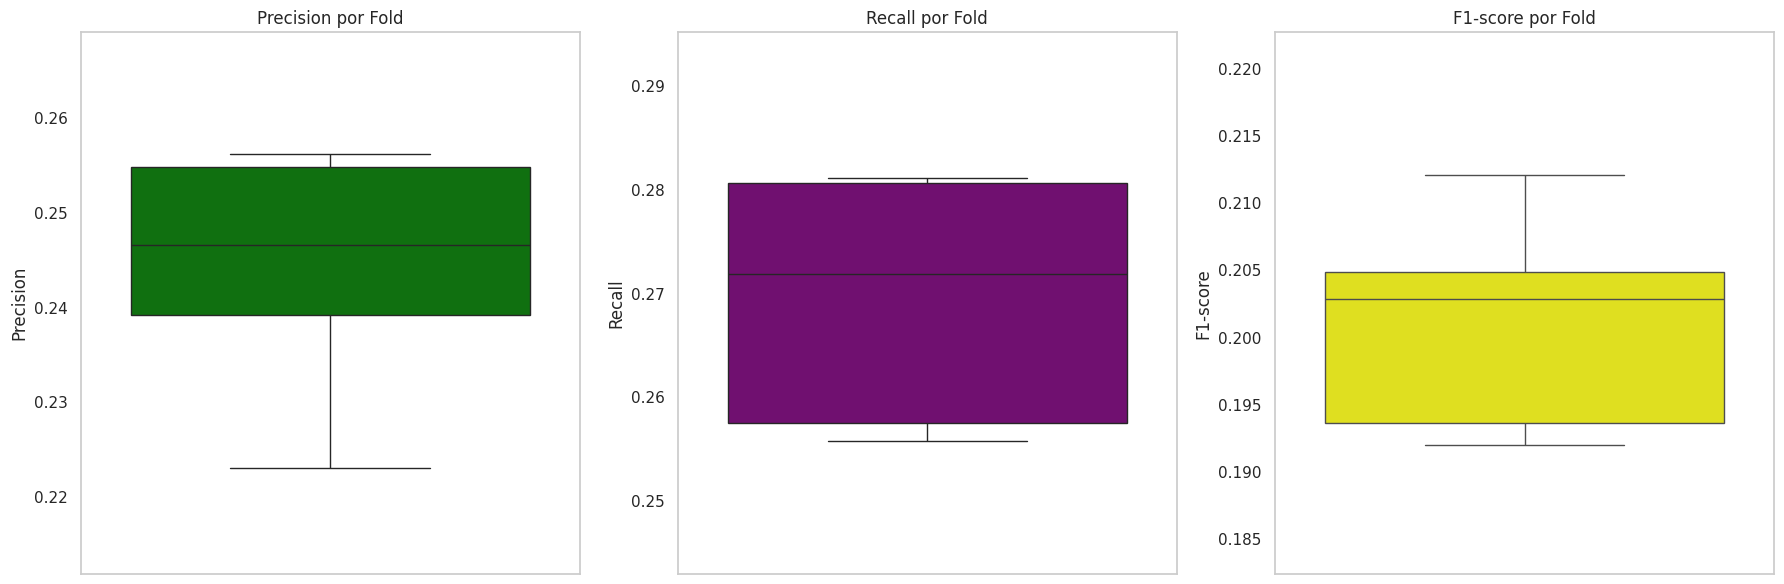

In [ ]:
metrics = ['precision', 'recall', 'f1-score']
cores = ['green', 'purple', 'yellow']
plt.figure(figsize=(18, 6))

sns.set(style="whitegrid")

for i, metric in enumerate(metrics):
    plt.subplot(1, 3, i + 1)
    sns.boxplot(y=metric, data=metrics_df_next, color=cores[i])
    plt.title(f'{metric.capitalize()} por Fold')
    plt.ylabel(metric.capitalize())

    min_val = metrics_df_next[metric].min() * 0.95
    max_val = metrics_df_next[metric].max() * 1.05
    plt.ylim(min_val, max_val)

    plt.grid(False)

plt.tight_layout()

metric_by_fold_nextpoi = '/tmp/metric-by-fold-nextpoi.png'
plt.savefig(metric_by_fold_nextpoi)

plt.show()

##### **PCat**

In [ ]:
metrics_df_category = calculate_metrics_by_fold(fold_results_test, 'category')
print('categorypoi test metrics by fold:\n')
print(metrics_df_category)

categorypoi test metrics by fold:

   fold  precision    recall  f1-score
0     1   0.283911  0.309416  0.277107
1     2   0.276079  0.316096  0.278790
2     3   0.289903  0.312304  0.290010
3     4   0.284071  0.313114  0.276984
4     5   0.263202  0.304617  0.270423


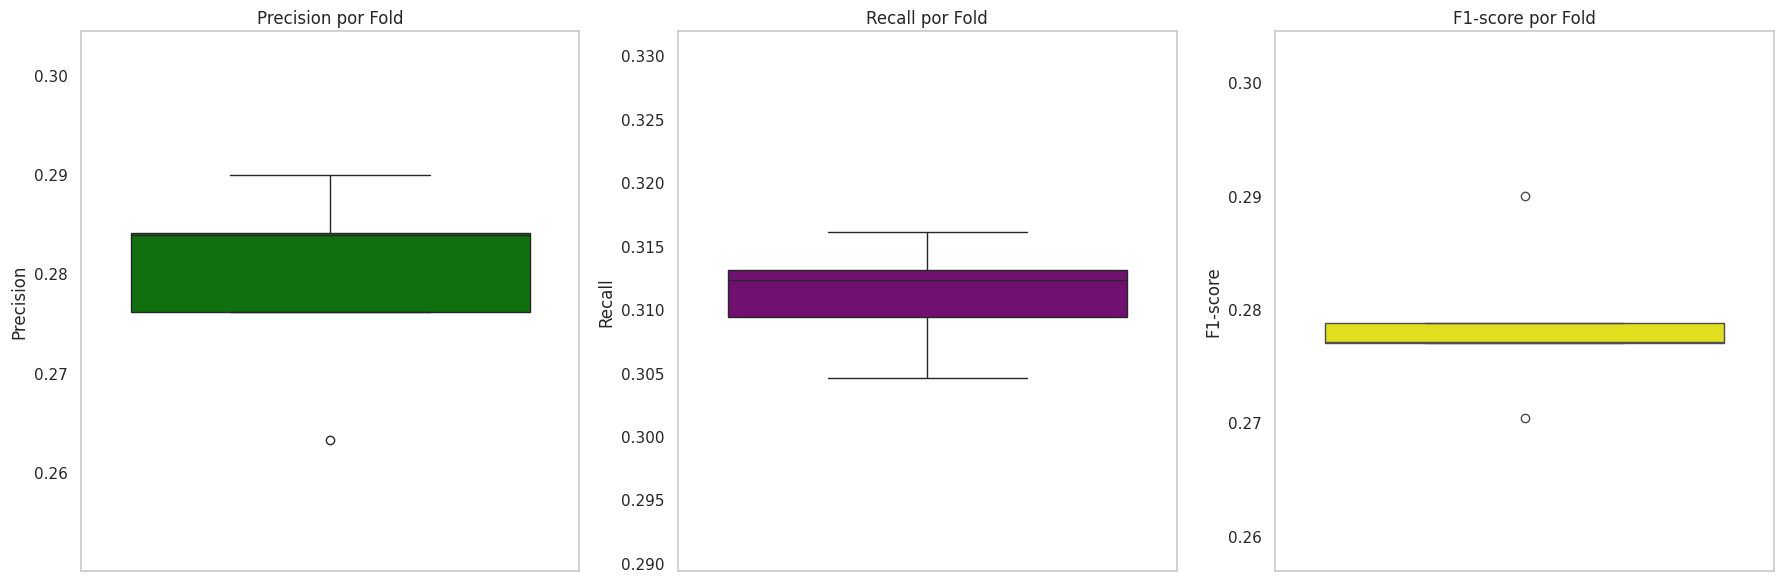

In [ ]:
metrics = ['precision', 'recall', 'f1-score']
cores = ['green', 'purple', 'yellow']
plt.figure(figsize=(18, 6))

sns.set(style="whitegrid")

for i, metric in enumerate(metrics):
    plt.subplot(1, 3, i + 1)
    sns.boxplot(y=metric, data=metrics_df_category, color=cores[i])
    plt.title(f'{metric.capitalize()} por Fold')
    plt.ylabel(metric.capitalize())

    min_val = metrics_df_category[metric].min() * 0.95
    max_val = metrics_df_category[metric].max() * 1.05
    plt.ylim(min_val, max_val)

    plt.grid(False)

plt.tight_layout()

metric_by_fold_categorypoi = '/tmp/metric-by-fold-categorypoi.png'
plt.savefig(metric_by_fold_categorypoi)

plt.show()

#### **Distribuição das Métricas de Teste**

In [ ]:
for fold in fold_results_test:
  print('"' * 85)
  print(f'FOLD {fold}\n')

  y_true_next = fold_results_test[fold]['test_next_true']
  y_pred_next = fold_results_test[fold]['test_next_pred']

  y_true_category = fold_results_test[fold]['test_category_true']
  y_pred_category = fold_results_test[fold]['test_category_pred']

  print_classification_report_test(y_true_next, y_pred_next, id_to_name, 'next')
  print_classification_report_test(y_true_category, y_pred_category, id_to_name, 'category')
  print()

"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
FOLD 1

next test metrics:
          Community Entertainment  Food Nightlife Outdoors Shopping Travel macro avg
precision      39.0           6.7  46.0      12.0      8.6     38.2   27.9      25.5
recall         42.2          32.0  10.2      43.2     34.2      1.8   32.8      28.1
f1-score       40.5          11.0  16.7      18.7     13.7      3.5   30.2      19.2

category test metrics:
          Community Entertainment  Food Nightlife Outdoors Shopping Travel macro avg
precision      33.1           9.3  54.4      31.8      8.0     50.1   11.9      28.4
recall         30.8           6.9  37.5      49.4     34.0     37.8   20.2      30.9
f1-score       31.9           7.9  44.4      38.7     12.9     43.1   15.0      27.7


"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
FOLD 2

next test metrics:
          Community Entertainment  Food Nightlife Outdoors Shopping 

#### **Evolução das Perdas**

##### **Durante o Treinamento**

###### **NPC**

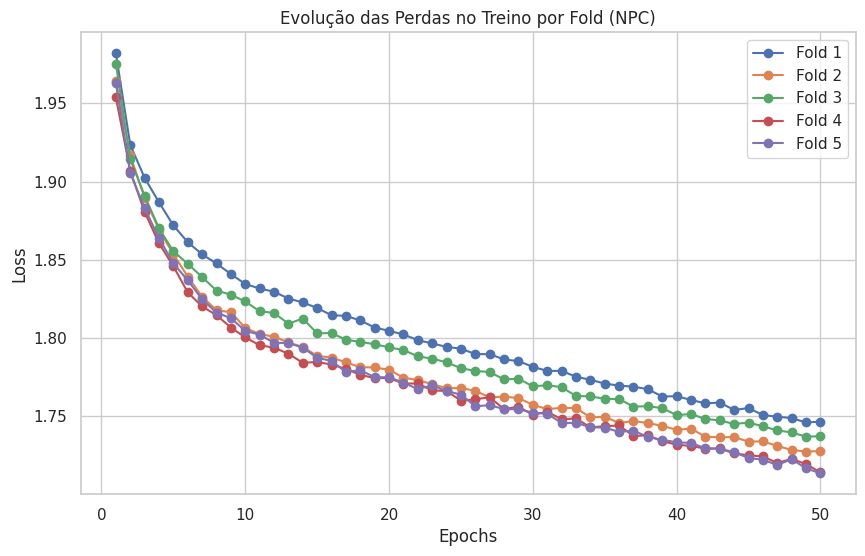

In [ ]:
num_folds = len(fold_losses_train)

plt.figure(figsize=(10, 6))

for fold in range(1, num_folds + 1):
    epochs = range(1, len(fold_losses_train[fold]['next_losses']) + 1)
    losses = fold_losses_train[fold]['next_losses']
    plt.plot(epochs, losses, marker='o', label=f'Fold {fold}')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Evolução das Perdas no Treino por Fold (NPC)')
plt.legend()
plt.grid(True)

next_train_loss_graph = "/tmp/loss-next-by-fold-.png"
plt.savefig(next_train_loss_graph)

plt.show()

###### **PCat**

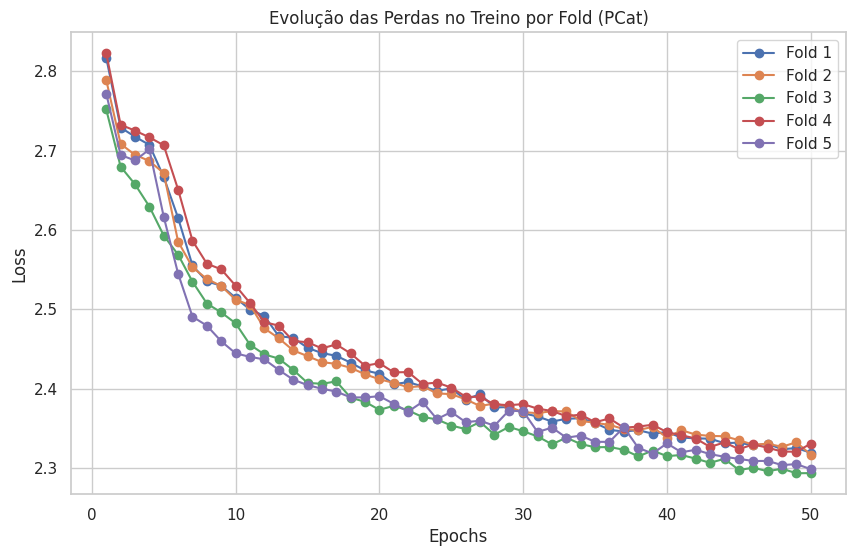

In [ ]:
num_folds = len(fold_losses_train)

plt.figure(figsize=(10, 6))

for fold in range(1, num_folds + 1):
    epochs = range(1, len(fold_losses_train[fold]['category_losses']) + 1)
    losses = fold_losses_train[fold]['category_losses']
    plt.plot(epochs, losses, marker='o', label=f'Fold {fold}')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Evolução das Perdas no Treino por Fold (PCat)')
plt.legend()
plt.grid(True)

cat_train_loss_graph = "/tmp/loss-category-by-fold-.png"
plt.savefig(cat_train_loss_graph)

plt.show()

##### **Durante a Validação**

###### **NPC**

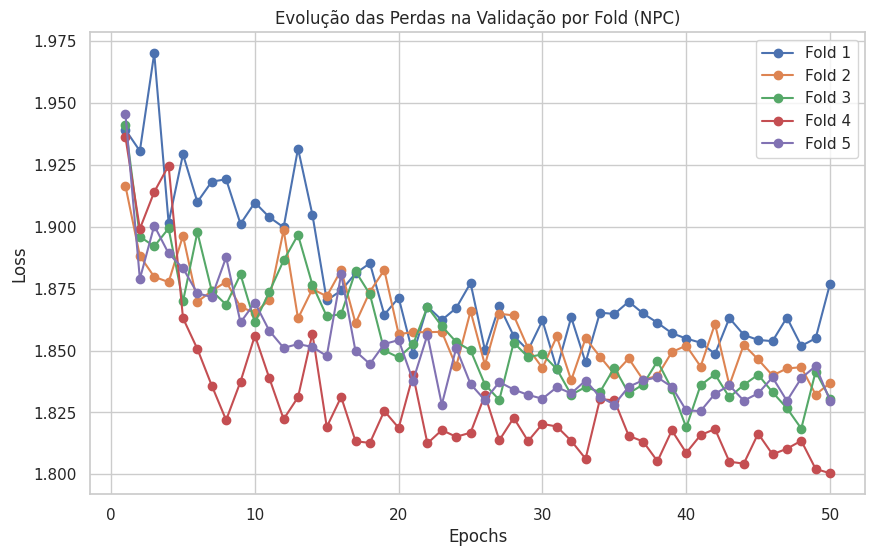

In [ ]:
num_folds = len(fold_losses_train)

plt.figure(figsize=(10, 6))

for fold in range(1, num_folds + 1):
    epochs = range(1, len(fold_losses_val[fold]['next_val_losses']) + 1)
    losses = fold_losses_val[fold]['next_val_losses']
    plt.plot(epochs, losses, marker='o', label=f'Fold {fold}')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Evolução das Perdas na Validação por Fold (NPC)')
plt.legend()
plt.grid(True)

next_val_loss_graph = "/tmp/next_val_loss_graph.png"
plt.savefig(next_val_loss_graph)

plt.show()

###### **PCat**

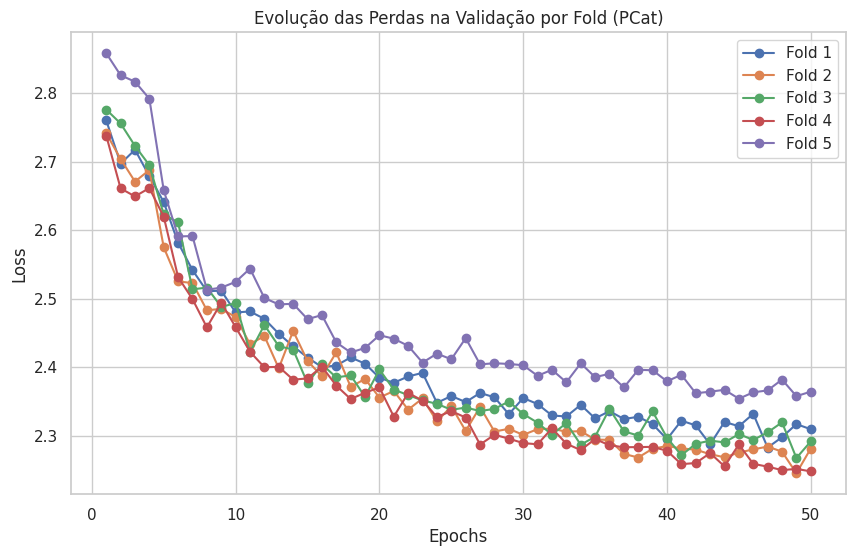

In [ ]:
num_folds = len(fold_losses_train)

plt.figure(figsize=(10, 6))

for fold in range(1, num_folds + 1):
    epochs = range(1, len(fold_losses_val[fold]['category_val_losses']) + 1)
    losses = fold_losses_val[fold]['category_val_losses']
    plt.plot(epochs, losses, marker='o', label=f'Fold {fold}')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Evolução das Perdas na Validação por Fold (PCat)')
plt.legend()
plt.grid(True)

cat_val_loss_graph = "/tmp/category_val_loss_graph.png"
plt.savefig(cat_val_loss_graph)

plt.show()

### **Salvar Resultados no Drive**

In [ ]:
model_name_next = 'NPC'
model_name_category = 'PCat'
state = 'arizona'

def _classification_report(y_true, y_pred, id_to_name, fold_num):
    report = classification_report(y_true, y_pred, zero_division=1, output_dict=True)
    metrics_df = pd.DataFrame(report).transpose()
    metrics_df = metrics_df.drop(columns='support')
    metrics_df.rename(index=id_to_name, inplace=True)
    metrics_df = metrics_df.transpose()
    metrics_df = metrics_df.map(lambda x: f"{x * 100:.1f}")
    accuracy = f"{report['accuracy'] * 100:.1f}"

    return metrics_df, accuracy

agg_metrics_list_next = []
metrics_list_next = []

agg_metrics_list_category = []
metrics_list_category = []

for fold in fold_results_test:
    y_true_next = fold_results_test[fold]['test_next_true']
    y_pred_next = fold_results_test[fold]['test_next_pred']
    report_next, accuracy_next = _classification_report(y_true_next, y_pred_next, id_to_name, fold)

    y_true_category = fold_results_test[fold]['test_category_true']
    y_pred_category = fold_results_test[fold]['test_category_pred']
    report_category, accuracy_category = _classification_report(y_true_category, y_pred_category, id_to_name, fold)

    df_metrics_next = report_next.copy()
    df_metrics_next.reset_index(inplace=True)
    df_metrics_next = df_metrics_next.rename(columns={'index': 'Metricas'})
    path_df = f'/tmp/next-metrics-fold{fold}.csv'
    df_metrics_next.to_csv(path_df)

    df_metricscategory = report_category.copy()
    df_metricscategory.reset_index(inplace=True)
    df_metricscategory = df_metricscategory.rename(columns={'index': 'Metricas'})
    path_df = f'/tmp/category-metrics-fold{fold}.csv'
    df_metricscategory.to_csv(path_df)

    # primeiro csv que gera um grafico
    agg_metrics_next = {
        'fold': fold,
        'model': model_name_next,
        'accuracy': accuracy_next,
        'macro avg': report_next.loc['f1-score', 'macro avg'],
        'weighted avg': report_next.loc['f1-score', 'weighted avg'],
        'state': state
    }
    agg_metrics_list_next.append(agg_metrics_next)

    agg_metrics_category = {
        'fold': fold,
        'model': model_name_category,
        'accuracy': accuracy_category,
        'macro avg': report_category.loc['f1-score', 'macro avg'],
        'weighted avg': report_category.loc['f1-score', 'weighted avg'],
        'state': state
    }
    agg_metrics_list_category.append(agg_metrics_category)

    # segundo csv que gera a tabela
    for categoria in report_next.columns:
        if categoria not in ['macro avg', 'weighted avg']:
            next_metrics = {
                'precision': report_next.loc['precision', categoria],
                'recall': report_next.loc['recall', categoria],
                'f1-score': report_next.loc['f1-score', categoria],
                'category': categoria,
                'accuracy': accuracy_next,
                'model': model_name_next,
                'state': state
            }
            metrics_list_next.append(next_metrics)

    for categoria in report_category.columns:
        if categoria not in ['macro avg', 'weighted avg']:
            next_metrics = {
                'precision': report_category.loc['precision', categoria],
                'recall': report_category.loc['recall', categoria],
                'f1-score': report_category.loc['f1-score', categoria],
                'category': categoria,
                'accuracy': accuracy_category,
                'model': model_name_category,
                'state': state
            }
            metrics_list_category.append(next_metrics)

agg_metrics_df_next = pd.DataFrame(agg_metrics_list_next)
category_metrics_next = pd.DataFrame(metrics_list_next)

agg_metrics_df_category = pd.DataFrame(agg_metrics_list_category)
category_metrics_category = pd.DataFrame(metrics_list_category)

In [ ]:
path_agg_metrics_next = f'/content/drive/MyDrive/Graduacao/POC/Dados/models-results/MTLPOI/{state}/NPC-general.csv'
path_category_metrics_next = f'/content/drive/MyDrive/Graduacao/POC/Dados/models-results/MTLPOI/{state}/NPC-all-metrics.csv'

path_agg_metrics_category = f'/content/drive/MyDrive/Graduacao/POC/Dados/models-results/MTLPOI/{state}/PCat-general.csv'
path_category_metrics_category = f'/content/drive/MyDrive/Graduacao/POC/Dados/models-results/MTLPOI/{state}/PCat-all-metrics.csv'

In [ ]:
agg_metrics_df_next.to_csv(path_agg_metrics_next, index=False)
category_metrics_next.to_csv(path_category_metrics_next, index=False)

agg_metrics_df_category.to_csv(path_agg_metrics_category, index=False)
category_metrics_category.to_csv(path_category_metrics_category, index=False)

In [ ]:
model_and_train_params = {
  'input_dim': 100,
  'shared_layer_size': 256,
  'num_classes': 7,
  'num_layers': 4,
  'num_heads': 8,
  'seq_length': 9,
  'lr': 0.0001,
  'num_epochs': 100,
  'n_splits': 5,
  'weight_decay': 1e-5,
  'num_shared_layers': 4,
}

In [ ]:
tasks = ['next', 'category']
num_folds = 5
epochs = 50
model_name = 'MTLPOI'

for task in tasks:
    task_losses_train_avg = []
    task_losses_val_avg = []

    for epoch in range(epochs):
        epoch_train_losses = []
        epoch_val_losses = []

        for fold in range(num_folds):
            epoch_train_losses.append(fold_losses_train[fold + 1][f'{task}_losses'][epoch])
            epoch_val_losses.append(fold_losses_val[fold + 1][f'{task}_val_losses'][epoch])

        task_losses_train_avg.append(np.mean(epoch_train_losses))
        task_losses_val_avg.append(np.mean(epoch_val_losses))

    df_losses = pd.DataFrame({
        'Epoch': range(1, epochs + 1),
        f'{task}_train_loss_avg': task_losses_train_avg,
        f'{task}_val_loss_avg': task_losses_val_avg
    })

    state = 'arizona'
    task_loss_path = f"/content/drive/MyDrive/Graduacao/POC/GerarResultados/ablation_study/{model_name}_losses_{task}_avg_{state}.csv"
    df_losses.to_csv(task_loss_path, index=False)

    print(f"Arquivo CSV gerado para a tarefa {task} e modelo {model_name}: {task_loss_path}")

Arquivo CSV gerado para a tarefa next e modelo MTLPOI: /content/drive/MyDrive/Graduacao/POC/GerarResultados/ablation_study/MTLPOI_losses_next_avg_arizona.csv
Arquivo CSV gerado para a tarefa category e modelo MTLPOI: /content/drive/MyDrive/Graduacao/POC/GerarResultados/ablation_study/MTLPOI_losses_category_avg_arizona.csv


### **Salvar Resultados no MlFlow**

In [ ]:
mlflow.end_run()

In [ ]:
import tempfile
import os

with mlflow.start_run(run_name='MTL-POI'):
    mlflow.log_params(model_and_train_params)
    torch.save(model.state_dict(), "mtlpoi.pth")
    mlflow.log_artifact("mtlpoi.pth", "Modelos")
    mlflow.log_artifact(next_train_loss_graph, "Perdas de Treino")
    mlflow.log_artifact(cat_train_loss_graph, "Perdas de Treino")
    mlflow.log_artifact(next_val_loss_graph, "Perdas de Validação")
    mlflow.log_artifact(cat_val_loss_graph, "Perdas de Validação")
    mlflow.log_artifact(metric_by_fold_nextpoi, "Distribuição das Métricas de Teste")
    mlflow.log_artifact(metric_by_fold_categorypoi, "Distribuição das Métricas de Teste")
    mlflow.log_artifact(path_agg_metrics_next, "Métrica F1-Score (NPC)")
    mlflow.log_artifact(path_agg_metrics_category, "Métrica F1-Score (PCat)")

    with tempfile.TemporaryDirectory() as tmpdir:
        metrics_df_next_path = os.path.join(tmpdir, "metrics_df_next.csv")
        metrics_df_category_path = os.path.join(tmpdir, "metrics_df_category.csv")

        metrics_df_next.to_csv(metrics_df_next_path, index=False)
        metrics_df_category.to_csv(metrics_df_category_path, index=False)

        mlflow.log_artifact(metrics_df_next_path, "Métricas de Teste (NPC)")
        mlflow.log_artifact(metrics_df_category_path, "Métricas de Teste (NPC)")

        for fold in fold_results_test:
            path_df_next = f'/tmp/next-metrics-fold{fold}.csv'
            mlflow.log_artifact(path_df_next, "Métricas de Teste Por Fold (NPC)")

            path_df_category = f'/tmp/category-metrics-fold{fold}.csv'
            mlflow.log_artifact(path_df_category, "Métricas de Teste por Fold (PCat)")

🏃 View run MTL-POI at: https://dagshub.com/ingredalmeida1/poc.mlflow/#/experiments/3/runs/67c0ff9c0267404986467fc28f7f019f
🧪 View experiment at: https://dagshub.com/ingredalmeida1/poc.mlflow/#/experiments/3
